RNN(LSTM)入門2日目。依然として、全然わかりません。このあたりが自分のスキルの限界なのかもしれない。

Udacity DLNDで株の値動きの予測をする動画が紹介された。

[![IMAGE ALT TEXT HERE](http://img.youtube.com/vi/ftMq5ps503w/0.jpg)](http://www.youtube.com/watch?v=ftMq5ps503w)

* [llSourcell/How-to-Predict-Stock-Prices-Easily-Demo: How to Predict Stock Prices Easily - Intro to Deep Learning #7 by Siraj Raval on Youtube](https://github.com/llSourcell/How-to-Predict-Stock-Prices-Easily-Demo)

[FXのシステムトレードを以前やっていた](http://futurismo.biz/archives/4392)ので、
DLで学んだことが生かせればいいなと思い、株を為替に置き換えて、LSTMで為替の値動きの予測をしてみた。

この記事は以下の記事をベースに書いている。

* [Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras - Machine Learning Mastery](http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)

また、以下のkaggleコンペのkernelsも大いに参考にした。

* [New York Stock Exchange | Kaggle](https://www.kaggle.com/dgawlik/nyse)

## 準備
まずは、為替データを準備する。以下のサイトから、2017/4/24 の USD/JPY の 10分刻みのデータをダウンロードする。

* [Historical Data Feed :: Dukascopy Bank SA | Swiss Forex Bank | ECN Broker | Managed accounts | Swiss FX trading platform](https://www.dukascopy.com/swiss/english/marketwatch/historical/)

githubにも使用したデータをアップロードした。

* [futurismo/USDJPY_Candlestick_10_m_BID_24.04.2017-25.04.2017.csv](https://github.com/tsu-nera/futurismo/blob/main/blog/ipynb/USDJPY_Candlestick_10_m_BID_24.04.2017-25.04.2017.csv)

### 環境
* TensorFlow 1.1.0
* Keras 2.0.2

## LSTM Network for Regression
チュートリアルにしたがって順にコードを書いていく。

In [1]:
from __future__ import print_function
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import math

Using TensorFlow backend.


In [2]:
# parameters to be set 
look_back = 1
epochs = 30
batch_size = 1

In [3]:
# fix random seed for reproducibility
np.random.seed(7)

### PrePare Data

In [4]:
# read all prices using panda
dataframe =  pd.read_csv('USDJPY_Candlestick_10_m_BID_24.04.2017-25.04.2017.csv',
                         header=0)
dataframe.head()

,Local time,Open,High,Low,Close,Volume
0,24.04.2017 00:00:00.000,109.072,109.072,109.072,109.072,0.0
1,24.04.2017 00:10:00.000,109.072,109.072,109.072,109.072,0.0
2,24.04.2017 00:20:00.000,109.072,109.072,109.072,109.072,0.0
3,24.04.2017 00:30:00.000,109.072,109.072,109.072,109.072,0.0
4,24.04.2017 00:40:00.000,109.072,109.072,109.072,109.072,0.0


In [5]:
dataset = dataframe['Close']

In [6]:
# reshape to column vector
#close_prices = close.values.reshape(len(close), 1)
dataset = dataset.values
dataset = dataset.astype('float32')
close_prices = dataset.reshape((-1,1))

ここで、データを0~1の間に正規化する。scikit-learnにMinMaxScalerという便利な関数があって、fit_transformとすると、正規化できる。戻すときは、inverse_transformをコールする。

In [7]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
close_prices = scaler.fit_transform(close_prices)

訓練用データを 2/3, テスト用データを 1/3に分ける。

In [8]:
# split data into training set and test set
train_size = int(len(close_prices) * 0.67)
test_size = len(close_prices) - train_size
train, test = close_prices[0:train_size,:], close_prices[train_size:len(close_prices),:]

print('Split data into training set and test set... Number of training samples/ test samples:', len(train), len(test))

Split data into training set and test set... Number of training samples/ test samples: 192 96


create_dataset()で訓練用のラベルを生成する。現在のデータから一つ先(look_back=1)のデータ、つまり10分後の値動きを予想する。

ちなみにこの関数は便利で、look_backを2にすると、２つ前のデータ、つまり現在と10分前のデータから10分後のデータを予測することができる。look_backパラメータを調整することで、過去のデータから10分後のデータを予測できる。これを元の記事では、Window Methodと書いてある。

In [9]:
# convert an array of values into a time series dataset 
# in form 
#                     X                     Y
# t-look_back+1, t-look_back+2, ..., t     t+1

def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

# convert Apple's stock price data into time series dataset
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
(trainX.shape, trainY.shape, testX.shape, testY.shape)

((190, 1), (190,), (94, 1), (94,))

In [10]:
# reshape input of the LSTM to be format [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
(trainX.shape, testX.shape)

((190, 1, 1), (94, 1, 1))

### Build Model & Training
Kerasを利用してLSTMネットワークのモデルを作り、トレーニングを実施する。


In [11]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size,verbose=2)

Epoch 1/30
1s - loss: 0.1224
Epoch 2/30
0s - loss: 0.0332
Epoch 3/30
0s - loss: 0.0204
Epoch 4/30
0s - loss: 0.0160
Epoch 5/30
0s - loss: 0.0117
Epoch 6/30
0s - loss: 0.0082
Epoch 7/30
0s - loss: 0.0056
Epoch 8/30
0s - loss: 0.0041
Epoch 9/30
0s - loss: 0.0034
Epoch 10/30
0s - loss: 0.0031
Epoch 11/30
0s - loss: 0.0030
Epoch 12/30
0s - loss: 0.0030
Epoch 13/30
0s - loss: 0.0029
Epoch 14/30
0s - loss: 0.0029
Epoch 15/30
0s - loss: 0.0030
Epoch 16/30
0s - loss: 0.0029
Epoch 17/30
0s - loss: 0.0029
Epoch 18/30
0s - loss: 0.0029
Epoch 19/30
0s - loss: 0.0029
Epoch 20/30
0s - loss: 0.0029
Epoch 21/30
0s - loss: 0.0030
Epoch 22/30
0s - loss: 0.0030
Epoch 23/30
0s - loss: 0.0029
Epoch 24/30
0s - loss: 0.0029
Epoch 25/30
0s - loss: 0.0030
Epoch 26/30
0s - loss: 0.0030
Epoch 27/30
0s - loss: 0.0030
Epoch 28/30
0s - loss: 0.0029
Epoch 29/30
0s - loss: 0.0029
Epoch 30/30
0s - loss: 0.0030


### Predict

In [12]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [13]:
# invert predictions and targets to unscaled
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [14]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.5f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.5f RMSE' % (testScore))

Train Score: 0.09638 RMSE
Test Score: 0.06509 RMSE


In [15]:
# shift predictions of training data for plotting
trainPredictPlot = np.empty_like(close_prices)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift predictions of test data for plotting
testPredictPlot = np.empty_like(close_prices)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(close_prices)-1, :] = testPredict

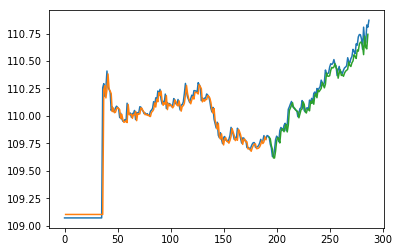

In [16]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(close_prices))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

予測結果は上の図。あまりにフィットしすぎて、なんかウソっぽいけれども、一応これが結果。

ちなみに、元の記事だとこの先もあるが、stepや state, stacked LSTMs が読んでもよくわからなかった。もう少し時間が必要。

* How to create an LSTM for a regression and a window formulation of the time series problem.
* How to create an LSTM with a time step formulation of the time series problem.
* How to create an LSTM with state and stacked LSTMs with state to learn long sequences.

元記事を元に試してみたけれども、修正を加えるたびに精度が悪くなっていくのだった。

## おわりに
LSTMを FXのストラテジに応用できるか考えてみたのだけれども、よいストラテジが思いつかない。

単純に回帰ならば、LSTMを使わなくてももっと簡単な方法がある。

トレーニングに時間がかかるので、リアルタイムに過去のデータを処理して未来の値を予測できるのか？

とはいえ、面白い話題なので、もう少し調べてみる。